In [1]:
import cv2
import numpy as np
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from dotenv import load_dotenv
 
load_dotenv(dotenv_path='/Users/daniel/OAN/SID/.env')

True

In [18]:
import sys
sys.path.append('/Users/daniel/OAN/SID/')

In [22]:
import sid_modules.helperFunctions as hf

In [2]:
conn = sqlite3.connect("casas.sqlite")

In [3]:
tables = pd.read_sql('SELECT name FROM sqlite_master WHERE type="table"',conn)
tables

,name
0,Sansi Gando
1,Monnon
2,Besen Gourou
3,Barkedje
4,Boudal


In [4]:
t1 = tables['name'][2]
t1

'Besen Gourou'

In [5]:
df = pd.read_sql('SELECT * FROM `{}`'.format(t1),conn)

In [6]:
df['houses'] = df['houses'].apply(eval)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   index    66 non-null     int64 
 1   houses   66 non-null     object
 2   type     66 non-null     object
 3   village  66 non-null     object
 4   size     66 non-null     object
dtypes: int64(1), object(4)
memory usage: 2.7+ KB


In [8]:
image_name = t1+"_5_19_500.png"

In [9]:
im = cv2.imread(image_name,cv2.COLOR_BGR2RGB)

In [59]:
houses = df.T.to_dict()
for i in houses:
    row = houses[i]
    house = row['houses']
    ttype = row['type']
    if ttype == 'metal':
        vertices = np.array(house,dtype=np.int32)
        pts = vertices.reshape((-1,1,2))
        cv2.polylines(im,[pts],isClosed=True,color=(0,0,255),thickness=5)
    if ttype == 'round':
        vertices = np.array(house,dtype=np.int32)
        pts = vertices.reshape((-1,1,2))
        cv2.polylines(im,[pts],isClosed=True,color=(0,255,0),thickness=5)


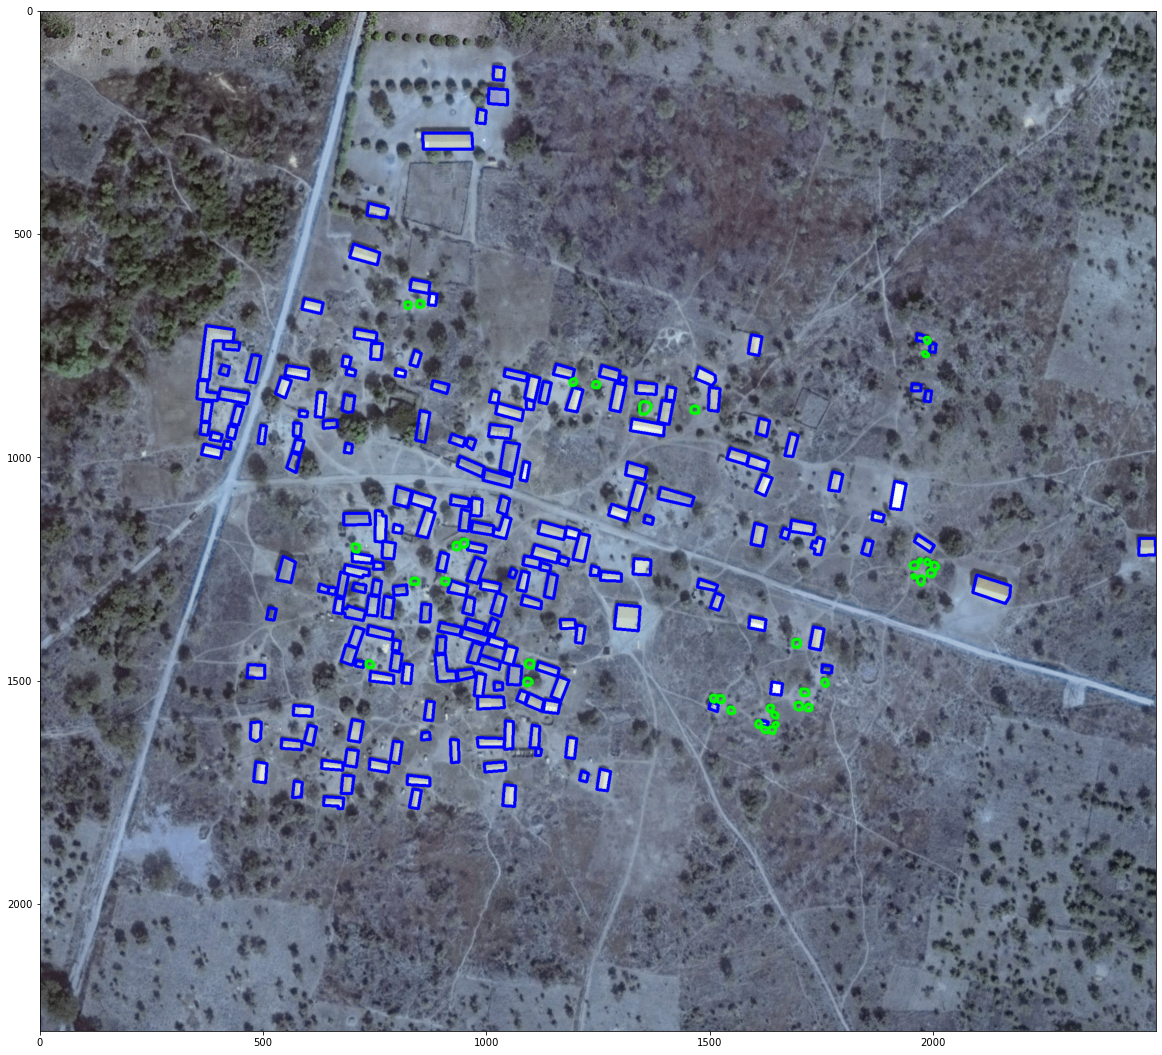

In [60]:
fig = plt.figure(figsize=(20,20))
plt.imshow(im)

## UPLOAD TO BIGQUERY

In [24]:
hf.SIDBuilding()

In [26]:
"""
district (str): district it belongs to [Biro, Nikki] 
    village (str): village it belongs to 

    analysis_method (str): analysis detection method [ml,edge,color]

    lat (float): lat in deg from the center
    lon (float): lon in deg from  the center

    perim (float): perimeter in km  
    area (float): area in km2

    boundary_lat(str): list of lat coords from the boundary
    boundary_lon(str): list of lon coords from the boundary

    polygon (Polygon): Polygon of the shape
    point (Point): Point in the center
"""


'\ndistrict (str): district it belongs to [Biro, Nikki] \n    village (str): village it belongs to \n\n    analysis_method (str): analysis detection method [ml,edge,color]\n\n    lat (float): lat in deg from the center\n    lon (float): lon in deg from  the center\n\n    perim (float): perimeter in km  \n    area (float): area in km2\n\n    boundary_lat(str): list of lat coords from the boundary\n    boundary_lon(str): list of lon coords from the boundary\n\n    polygon (Polygon): Polygon of the shape\n    point (Point): Point in the center\n'

In [10]:
df = pd.DataFrame()

In [11]:
for table in tables['name']:
    print(table)
    df_vil = pd.read_sql('SELECT * FROM `{}`'.format(table),conn)
    df= df.append(df_vil)

Sansi Gando
Monnon
Besen Gourou
Barkedje
Boudal


In [12]:
df = df[['houses','type','village']].copy()

In [27]:
trad_im = {
    'Sansi Gando':
    {'im':'Sansi Gando_5_19_500.png',
    'district':'Biro'},
    'Monnon':{'im':'Monnon_5_19_500.png',
    'district':'Nikki'},
    'Besen Gourou':{'im':'Besen Gourou_5_19_500.png',
    'district':'Biro'},
    'Barkedje':{'im':'Barkedje_5_19_500.png',
    'district':'Nikki'},
    'Boudal':{'im':'Boudal_5_19_500.png',
    'district':'Nikki'}
    
}

In [28]:
df['image'] = df['village'].apply(lambda x: trad_im[x]['im'])

In [29]:
df['district'] = df['village'].apply(lambda x: trad_im[x]['district'])

In [30]:
df['analysis_method'] = 'manual'

In [31]:
df['houses'] = df['houses'].apply(eval)

In [32]:
df['lat'] = df['houses'].apply(lambda x: np.mean([a[0] for a in x]))

In [34]:
df['lon'] = df['houses'].apply(lambda x: np.mean([a[1] for a in x]))

In [35]:
df['boundary_lat'] = df['houses'].apply(lambda x: str([a[0] for a in x]))

In [36]:
df['boundary_lon'] = df['houses'].apply(lambda x: str([a[1] for a in x]))

In [37]:
df['perim'] = 0

In [38]:
df['area'] = 0

In [39]:
df.to_gbq(
    'output_data.poc_buildings_from_labeled',
    project_id='sidhouses',
    if_exists='replace')

1it [00:02,  2.65s/it]
